In [2]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context('paper')
sns.set_style('white')

def load(dataset, metric='test_acc'):
    df = pd.read_csv(f"../results/finetuning_results_{dataset}_{metric}.csv")
    df.loc[:, "model"]= df.apply(lambda d:d.pretrained_model.split("_")[-1], axis=1)
    df.loc[:, "pretraining_dataset"]= df.apply(lambda d:'_'.join(d.pretrained_model.split("_")[:-1]), axis=1)
    df = df.drop_duplicates(subset=["model", "pretraining_dataset", "shot", "seed"], keep='last') # remove redundant metric reports due to resume
    df.metric_value *= 100
    return df

def get_color(model):
    return {
        'imagenet1k_bit50x1': 'skyblue',
        'imagenet21k_bit50x1': 'steelblue',
        'imagenet1k_bit152x4': 'navajowhite',
        'imagenet21k_bit152x4': 'darkorange',

        'chexpert_bit50x1': 'lightgreen',
        'chexpert_mimic_bit50x1': 'mediumseagreen',
        'chexpert_mimic_nih_bit50x1': 'forestgreen',
        'chexpert_mimic_nih_padchest_bit50x1': 'darkgreen',

        'chexpert_bit152x4': 'pink',
        'chexpert_mimic_bit152x4': 'lightcoral',
        'chexpert_mimic_nih_bit152x4': 'red',
        'chexpert_mimic_nih_padchest_bit152x4': 'darkred',

    }[model]

def get_dataset_caption(dataset):
    return {
        'imagenet1k': 'ImageNet-1k',
        'imagenet21k': 'ImageNet-21k',
        'chexpert': 'CheXpert',
        'chexpert_mimic': 'CheXpert-MIMIC',
        'chexpert_mimic_nih': 'CheXpert-MIMIC-NIH',
        'chexpert_mimic_nih_padchest': 'CheXpert-MIMIC-NIH-PadChest',
        
        'padchest': 'PadChest-Cl',
        'tuberculosis_full': 'Tuberculosis',
        'covidx_cxr2': 'COVIDx',
        'cifar100': 'CIFAR-100',
        'cifar10': 'CIFAR-10',
        'flowers': 'Flowers-102',
        'flowers_oversampling': 'Flowers-102',
        'pneumonia': 'Pneumonia',
    }[dataset]

def get_model_caption(model):
    return {
        'bit50x1': 'R50x1',
        'bit152x4': 'R152x4',
    }[model]

def get_caption(data_model):
    *data, model = data_model.split('_')
    return get_model_caption(model) + ' on ' + get_dataset_caption('_'.join(data))

def get_fewshot_caption(fs):
    return fs.split('_')[0].capitalize() + ' Shot'

def get_metric_caption(metric):
    return {
        'test_mean_auc': 'Test Mean AUC',
        'test_acc': 'Test Accuracy',
    }[metric]

# Bar plot

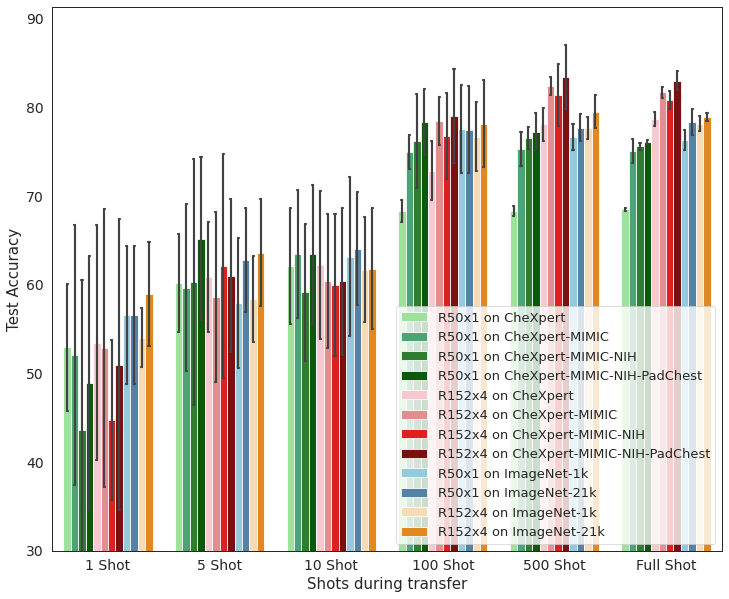

In [13]:
which_plot = 'covidx_cxr2'
assert which_plot in ('cifar10','cifar100','pets','flowers_oversampling','covidx_cxr2','padchest','tuberculosis_full')


dataset = which_plot
metric = 'test_mean_auc' if which_plot == 'padchest' else 'test_acc'
captions = True
df = load(dataset, metric)
fewshot_order = ['1_shot', '5_shot', '10_shot', '100_shot', '500_shot', 'full_shot']
order = [fs for fs in fewshot_order if fs in set(df.shot.unique())]
captions = False

if which_plot in ('cifar10', 'cifar100', 'flowers', 'pets', 'flowers_oversampling'):
    hue_order = [
        'imagenet1k_bit50x1', 
        'imagenet21k_bit50x1', 
        'imagenet1k_bit152x4', 
        'imagenet21k_bit152x4'
    ]
elif which_plot == 'covidx_cxr2':
    hue_order = [
        'chexpert_bit50x1', 
        'chexpert_mimic_bit50x1', 
        'chexpert_mimic_nih_bit50x1', 
        'chexpert_mimic_nih_padchest_bit50x1', 

        'chexpert_bit152x4', 
        'chexpert_mimic_bit152x4', 
        'chexpert_mimic_nih_bit152x4', 
        'chexpert_mimic_nih_padchest_bit152x4', 

        'imagenet1k_bit50x1', 
        'imagenet21k_bit50x1', 
        'imagenet1k_bit152x4', 
        'imagenet21k_bit152x4'
    ]
elif which_plot == 'padchest':
    hue_order = [

    'chexpert_bit50x1', 
    'chexpert_mimic_bit50x1', 
    'chexpert_mimic_nih_bit50x1', 

    'chexpert_bit152x4', 
    'chexpert_mimic_bit152x4', 
    'chexpert_mimic_nih_bit152x4', 
    
    'imagenet1k_bit50x1', 
    'imagenet21k_bit50x1', 
    'imagenet1k_bit152x4', 
    'imagenet21k_bit152x4'
]
else:
    hue_order = [
        'chexpert_bit50x1', 
        'chexpert_mimic_bit50x1', 
        'chexpert_mimic_nih_bit50x1', 
        'chexpert_mimic_nih_padchest_bit50x1', 

        'chexpert_bit152x4', 
        'chexpert_mimic_bit152x4', 
        'chexpert_mimic_nih_bit152x4', 
        'chexpert_mimic_nih_padchest_bit152x4', 

        'imagenet1k_bit50x1', 
        'imagenet21k_bit50x1', 
        'imagenet1k_bit152x4', 
        'imagenet21k_bit152x4'
    ]
 
        
palette = [get_color(m) for m in hue_order]
fig_height = 10
fig_width = 12

fig = plt.figure(figsize=(fig_width, fig_height))
labels_fontsize = 14
axis_labels_fontsize = 15

g = sns.barplot(
    x='shot', y='metric_value', 
    hue='pretrained_model', 
    data=df, 
    order=order,
    hue_order=hue_order,
    palette=palette,
    capsize=0.01,
    edgecolor = 'w',
    ci='sd',
)

if captions:
    for p in g.patches:
        value = f'{round(p.get_height(), 2)}%'
        g.annotate(value, 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

g.set_xlabel(f"Shots during transfer",fontsize=axis_labels_fontsize)
g.set_ylabel(get_metric_caption(metric),fontsize=axis_labels_fontsize)

g.tick_params(axis="x", labelsize=labels_fontsize)
g.tick_params(axis="y", labelsize=labels_fontsize)
if which_plot not in ('cifar100',):
    g.set_ylim(ymin=30)
#g.set_ylim(ymin=35)
L = g.legend(title="", prop={'size':13})
for i, setup in enumerate(hue_order):
    L.get_texts()[i].set_text(get_caption(setup))
plt.xticks(ticks=range(len(order)),labels=list(map(get_fewshot_caption, order)))
plt.savefig(f"{which_plot}_barplot.pdf",dpi = 1000, format = 'pdf', bbox_inches = 'tight')
plt.show()

# Line Plot

50


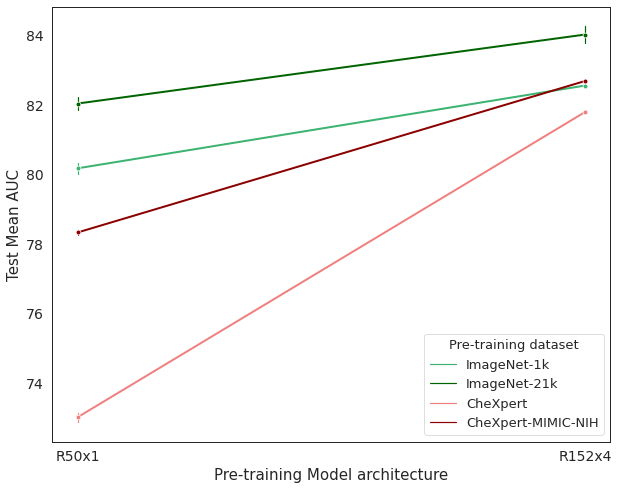

In [7]:
which_plot = 'covidx_cxr2'
assert which_plot in ('cifar10','cifar100','pets','flowers_oversampling','covidx_cxr2','padchest','tuberculosis_full')


metric = 'test_mean_auc' if which_plot == 'padchest' else 'test_acc'
df = load(which_plot,metric=metric)
df = df[df.shot=='full_shot']
print(len(df))
df['setup'] =  df.apply(lambda d:d.pretraining_dataset+'_'+d.shot, axis=1)

if which_plot == 'covidx_cxr2':
    hue_order = [
        'imagenet1k',
        'imagenet21k',
        'chexpert', 
        'chexpert_mimic_nih_padchest', 
    ]
elif which_plot == 'padchest':
    hue_order = [
        'imagenet1k',
        'imagenet21k',
        'chexpert', 
        'chexpert_mimic_nih', 
    ]
elif which_plot in ('cifar10', 'cifar100', 'flowers', 'pets'):
    hue_order = ['imagenet1k', 'imagenet21k']
else:
    hue_order = [
        'imagenet1k',
        'imagenet21k',
        'chexpert', 
        'chexpert_mimic_nih_padchest', 
    ]

    
palette = [
    'mediumseagreen',
    'darkgreen',
    'lightcoral',
    'darkred',
]
palette = palette[:len(hue_order)]
df = df[df.pretraining_dataset.isin(hue_order)]
model_order = ['bit50x1', 'bit152x4']
def key(s):
    return s.apply(lambda si:str(model_order.index(si)))
df = df.sort_values(by='model', key=key)

fig_height = 8
fig_width = 10

fig = plt.figure(figsize=(fig_width, fig_height))
labels_fontsize = 14
axis_labels_fontsize = 15
legend_fontsize = 13
legent_title_fontsize = legend_fontsize

ax = sns.lineplot(
    x='model',
    y='metric_value',
    data=df,
    hue='pretraining_dataset',
    sort=False,
    marker='o',
    ci='sd',
    err_style='bars',
    hue_order=hue_order,
    palette=palette,
    linewidth=2,
)
ax.set_xlabel("Pre-training Model architecture",fontsize=axis_labels_fontsize)
ax.set_ylabel(get_metric_caption(metric),fontsize=axis_labels_fontsize)

ax.tick_params(axis="x", labelsize=labels_fontsize)
ax.tick_params(axis="y", labelsize=labels_fontsize)

L = ax.legend(prop={'size':legend_fontsize})
L.set_title('Pre-training dataset',prop={'size': legent_title_fontsize})
for i, setup in enumerate(hue_order):
    L.get_texts()[i].set_text(get_dataset_caption(setup))
plt.xticks(ticks=range(len(model_order)),labels=list(map(get_model_caption, model_order)))
plt.savefig(f"{which_plot}_lineplot.pdf",dpi = 1000, format = 'pdf', bbox_inches = 'tight')
plt.show()

# Few-shot line plot

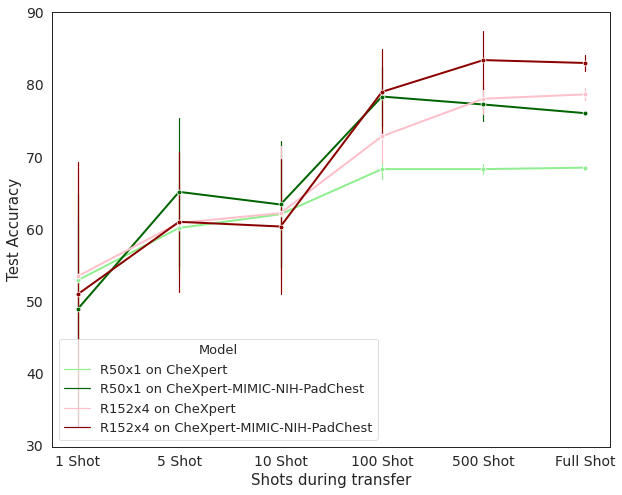

In [14]:
which_plot = 'covidx_cxr2'
assert which_plot in ('cifar10','cifar100','pets','flowers_oversampling','covidx_cxr2','padchest','tuberculosis_full')
which_pretraining = 'medical'
assert which_pretraining in ('natural', 'medical')

metric = "test_mean_auc" if which_plot == 'padchest' else 'test_acc'
df = load(which_plot,metric=metric)
df['setup'] =  df.apply(lambda d:d.pretraining_dataset+'_'+d.model, axis=1)

df = df.rename({
    'setup': 'Model'
}, axis=1)

fewshot_order = ['1_shot','5_shot','10_shot', '100_shot', '500_shot', 'full_shot']
fewshot_order = [fs for fs in fewshot_order if fs in set(df.shot.unique())]

def key(s):
    return s.apply(lambda si:str(fewshot_order.index(si)))
df = df.sort_values(by='shot', key=key)

fig_height = 8
fig_width = 10

fig = plt.figure(figsize=(fig_width, fig_height))
labels_fontsize = 14
axis_labels_fontsize = 15
legend_fontsize = 13
legent_title_fontsize = legend_fontsize

if which_pretraining == 'medical':
    if which_plot == 'padchest':
        hue_order = [
            'chexpert_bit50x1', 
            'chexpert_mimic_nih_bit50x1', 
            'chexpert_bit152x4', 
            'chexpert_mimic_nih_bit152x4',
        ]
    else:
        hue_order = [
            'chexpert_bit50x1', 
            'chexpert_mimic_nih_padchest_bit50x1', 
            'chexpert_bit152x4', 
            'chexpert_mimic_nih_padchest_bit152x4',
        ]
elif which_pretraining == 'natural':
    hue_order = [
        'imagenet1k_bit50x1',
        'imagenet21k_bit50x1',
        'imagenet1k_bit152x4',
        'imagenet21k_bit152x4',
    ]

palette = [get_color(m) for m in hue_order]

ax = sns.lineplot(
    x='shot',
    y='metric_value',
    data=df,
    hue='Model',
    sort=False,
    marker='o',
    ci='sd',
    err_style='bars',
    hue_order=hue_order,
    palette=palette,
    linewidth=2,
    #legend=False,
    #order=['bit_50x1', 'bit_152x4']
)

ax.set_xlabel(f"Shots during transfer",fontsize=axis_labels_fontsize)
ax.set_ylabel(get_metric_caption(metric),fontsize=axis_labels_fontsize)

ax.tick_params(axis="x", labelsize=labels_fontsize)
ax.tick_params(axis="y", labelsize=labels_fontsize)

L = ax.legend(prop={'size':legend_fontsize})
L.set_title('Model',prop={'size': legent_title_fontsize})

for i, setup in enumerate(hue_order):
    L.get_texts()[i].set_text(get_caption(setup))
    
plt.xticks(ticks=range(len(fewshot_order)),labels=list(map(get_fewshot_caption, fewshot_order)))
plt.savefig(f"{which_plot}_fewshot_from_{which_pretraining}.pdf",dpi = 1000, format = 'pdf', bbox_inches = 'tight')

plt.show()